# Quantum LSTM for part-of-speech tagging

In this example we will train a Quantum Long Short-Term Memory model to predict word types in sentences.

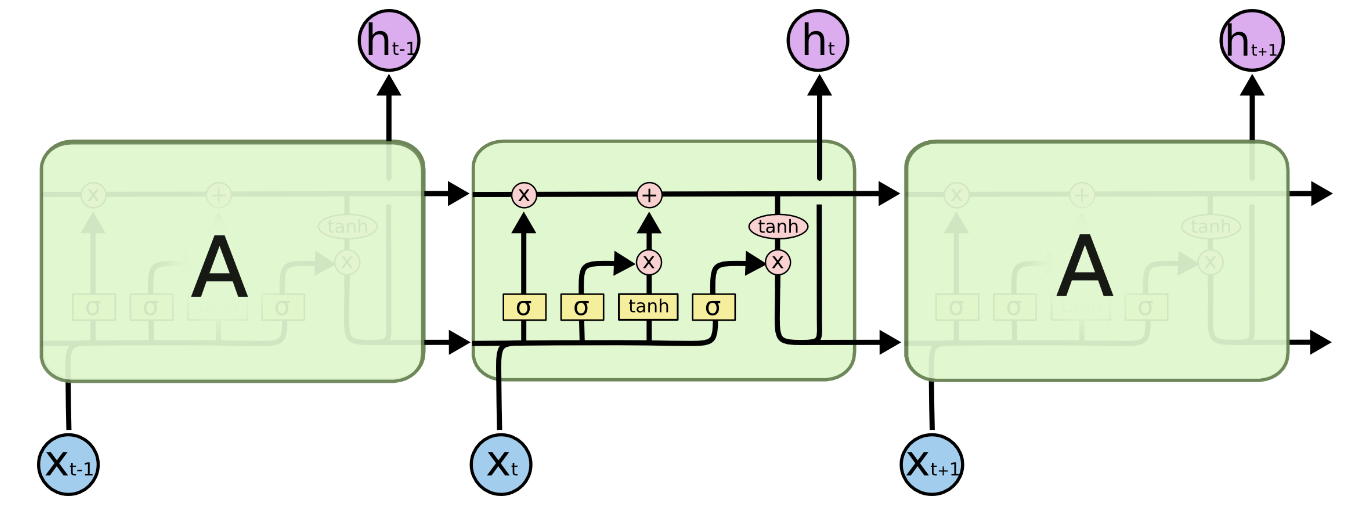

In [35]:
Image(filename='../Figures/lstmblocks.png', width=1000)

For this task, the predicted label for the *t*-th word in a sentence is extracted from the hidden state at step *t*.<br>

Let us start by importing some libraries and reading the relevant datasets.

In [1]:
import sys; sys.path.append('../src')
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
cmap = matplotlib.colormaps.get_cmap('tab20c')
colors = cmap.colors

In [2]:
from discocat_aux import read_data

train_labels, train_data = read_data('../Datasets/mc_train_data.txt')
val_labels, val_data = read_data('../Datasets/mc_test_data.txt')
test_labels, test_data = read_data('../Datasets/mc_test_data.txt')

In this case, the label of a sentence is a list with indexes specifying its word types. To assign labels to the sentences in the dataset, we build a dictionary assigning a type to each word.

In [3]:
type_idx = {'N': 0, 'V': 1, 'Adj': 2}
idx_type = {idx: tag for tag, idx in type_idx.items()}

In [13]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('S', 'N'), verbose='suppress')
raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

In [14]:
train_diagrams = []
val_diagrams = []
test_diagrams = []

for i, diagram in enumerate(raw_train_diagrams):
    if diagram is not None: train_diagrams.append(diagram.normal_form())
for i, diagram in enumerate(raw_val_diagrams):
    if diagram is not None: val_diagrams.append(diagram.normal_form())
for i, diagram in enumerate(raw_test_diagrams):
    if diagram is not None: test_diagrams.append(diagram.normal_form())

space_type = {'n': 'N', 'nsn': 'V', 'nn': 'Adj'}
word_type = {}

for i, diagram in enumerate(train_diagrams+val_diagrams+test_diagrams):
    for j, word in enumerate(diagram.to_tree()['inside']):
        if 'name' in word['inside'][1].keys():
            if word['inside'][1]['name'] in word_type.keys(): continue
            else:
                for k, space in enumerate(word['inside'][1]['cod']['inside']):
                    if k == 0: wtype = space['name']
                    else: wtype += space['name']
                word_type[word['inside'][1]['name']] = space_type[wtype]

The dictionary for the dataset is shown below.

In [31]:
for (word, type) in word_type.items():
    print('{}: {}'.format(word, type))

skillful: Adj
man: N
prepares: V
sauce: N
bakes: V
dinner: N
woman: N
cooks: V
tasty: Adj
meal: N
debugs: Adj
program: N
person: N
runs: V
useful: Adj
application: N
software: N


We then proceed to assing the labels.

In [16]:
training_data = []
validation_data = []
testing_data = []

for i, data in enumerate(train_data):
    sentence = []
    tags = []
    for word in data.split():
        try:
            tags.append(word_type[word])
            sentence.append(word)
        except: continue
    training_data.append((sentence, tags))

for i, data in enumerate(val_data):
    sentence = []
    tags = []
    for word in data.split():
        try:
            tags.append(word_type[word])
            sentence.append(word)
        except: continue
    validation_data.append((sentence, tags))

for i, data in enumerate(test_data):
    sentence = []
    tags = []
    for word in data.split():
        try:
            tags.append(word_type[word])
            sentence.append(word)
        except: continue
    testing_data.append((sentence, tags))

word_idx = {}

for sentence, tags in training_data+validation_data+testing_data:
    for word in sentence:
        if word not in word_idx: # word has not been assigned an index yet
            word_idx[word] = len(word_idx)

The QLSTM model for part-of-speech tagging is defined in *qlstm_models.py*. It was build on top of the QLSTM model at https://github.com/rdisipio/qlstm . We train it using *PyTorch*, the negative log likelihood loss function and the Adam gradient descent optimizer.

In [63]:
from qlstm_models import QLSTMTagger

embedding_dim = 8 # Dimension of the vector representing the word
hidden_dim = 6 # 
n_qubits = 2
backend = 'default.qubit'

model = QLSTMTagger(embedding_dim,
                    hidden_dim,
                    vocab_size=len(word_idx),
                    tagset_size=len(type_idx),
                    n_qubits=n_qubits,
                    backend=backend)

Unlike the *QLSTMClassifier* class, which calculates the sentence's tag score from the last hidden state as shown below,

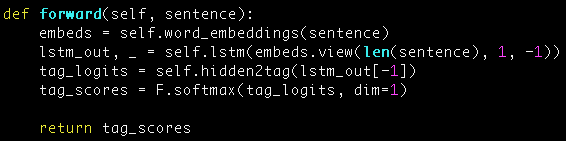

In [64]:
Image(filename='../Figures/qlstmclassifier.png', width=700)

the *QLSTMTagger* class in *qlstm_models.py* calculates the sentence's tag score from the hidden states in every memory block, allowing us to assign a tag to each word.

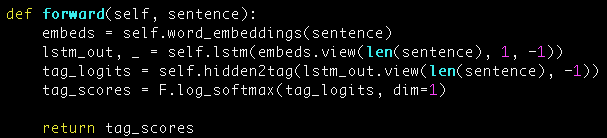

In [65]:
Image(filename='../Figures/qlstmtagger.png', width=700)

In [66]:
learning_rate = 0.001

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
training = {'loss': [], 'acc': []}
n_epochs = 30

In [68]:
from numpy import mean, around
from numpy.random import shuffle
from qlstm_aux import prepare_sequence
'''
# To parallelize the model training, we split the training dataset among multiple MPI processes.
# The gradient of the loss functrion are communicated before updating the parameters.

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

jobs_per_rank = len(train_data) // size
leftover = len(train_data) % size
if rank > size-leftover-1: jobs_per_rank += 1
jobsizes = comm.allgather(jobs_per_rank)
starts = list(sum(jobsizes[:i]) for i in range(len(jobsizes)))
rank_idxs = list(train_idxs[i] for i in range(starts[rank], starts[rank] + jobsizes[rank]))

# Parallel version would require to replace train_idxs below for rank_idxs
'''
for epoch in range(n_epochs):

    rank_losses = []
    rank_preds = []
    rank_targets = []
    accuracy = torch.tensor([0], dtype=torch.float32)
    
    for sentence, tags in training_data:
        
        model.zero_grad()

        sentence_in = prepare_sequence(sentence, word_idx)
        labels = prepare_sequence(tags, type_idx)

        tag_scores = model(sentence_in)

        loss = loss_function(tag_scores, labels)
        loss.backward()
        '''
        for param in model.parameters():
            temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
            comm.Allreduce(param.grad, temp, op=MPI.SUM)
            param.grad = temp

        if num_qubits > 0:
            for param in model.lstm.VQC['forget'].parameters():
                temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
                comm.Allreduce(param.grad, temp, op=MPI.SUM)
                param.grad = temp
            for param in model.lstm.VQC['input'].parameters():
                temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
                comm.Allreduce(param.grad, temp, op=MPI.SUM)
                param.grad = temp
            for param in model.lstm.VQC['update'].parameters():
                temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
                comm.Allreduce(param.grad, temp, op=MPI.SUM)
                param.grad = temp
            for param in model.lstm.VQC['output'].parameters():
                temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
                comm.Allreduce(param.grad, temp, op=MPI.SUM)
                param.grad = temp
        '''
        optimizer.step()
        
        rank_losses.append(float(loss))

        probs = torch.softmax(tag_scores, dim=-1)
        rank_preds.append(probs.argmax(dim=-1))
        rank_targets.append(labels)
    '''
    losses = []
    preds = []
    targets = []

    temp = comm.allgather(rank_losses)
    for sublist in temp: losses += list(item for item in sublist)
    temp = comm.allgather(rank_preds)
    for sublist in temp: preds += list(item for item in sublist)
    temp = comm.allgather(rank_targets)
    for sublist in temp: targets += list(item for item in sublist)
    if epoch == num_epochs-1:
        temp = comm.allgather(rank_confusion)
        confusion = {c: [] for c in classes}
        for sublist in temp:
            for c in classes: confusion[c] += sublist[c]
    '''
    avg_loss = mean(rank_losses)
    training['loss'].append(avg_loss)
    
    preds = torch.cat(rank_preds)
    targets = torch.cat(rank_targets)
    corrects = (preds == targets)
    accuracy = corrects.sum().float() / float(targets.size(0) )
    training['acc'].append(accuracy.detach().numpy())

    if epoch%10==0: print('Epoch: {}\tLoss: {}\tAccuracy: {}'.format(epoch, around(avg_loss,4), around(accuracy,4)))

Epoch: 0	Loss: 1.0772	Accuracy: 0.3779999911785126
Epoch: 10	Loss: 0.4965	Accuracy: 0.8424999713897705
Epoch: 20	Loss: 0.2666	Accuracy: 0.9764000177383423


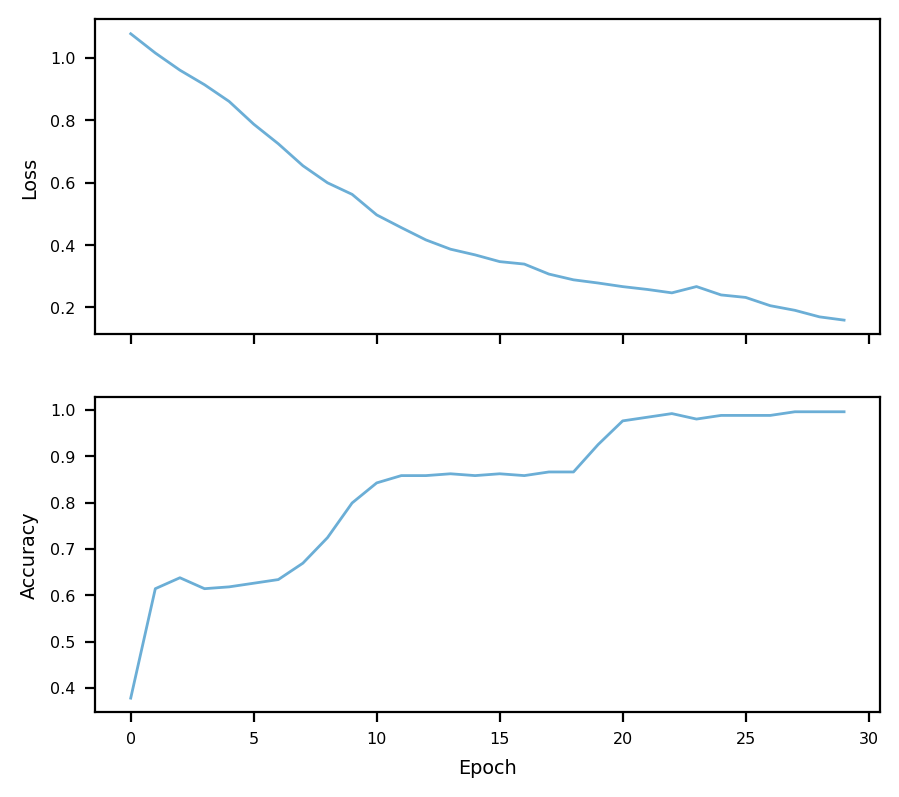

In [69]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(3.375*3/2, 3.375*4/3), dpi=200)
for ax in axs.ravel():
    ax.tick_params(labelsize='xx-small')
axs[0].set_ylabel('Loss', fontsize='x-small')
axs[1].set_ylabel('Accuracy', fontsize='x-small')
axs[1].set_xlabel('Epoch', fontsize='x-small')
axs[0].plot(training['loss'], lw=1, color=colors[1], label='Q'*(n_qubits>0)+'LSTM');
axs[1].plot(training['acc'], lw=1, color=colors[1], label='Q'*(n_qubits>0)+'LSTM');

Below the model is used to predict the part-of-speech tags on the test set.

In [86]:
test = 4
for word in testing_data[test][0]:
    print(word, end=' ')
print('\n')
print('\t\t\t', idx_type)

with torch.no_grad():
    inputs = prepare_sequence(testing_data[test][0], word_idx)
    tag_scores = model(inputs)

    for i, tag in enumerate(torch.argmax(tag_scores,dim=-1).detach().numpy()):
        print('{}: {}\t\t{}'.format(testing_data[test][0][i], idx_type[tag], tag_scores[i].detach().numpy()))

skillful woman cooks sauce 

			 {0: 'N', 1: 'V', 2: 'Adj'}
skillful: Adj		[-3.2377667  -2.4404497  -0.13510191]
woman: N		[-0.00952745 -4.904322   -6.1812663 ]
cooks: V		[-2.6482775  -0.18589565 -2.3139815 ]
sauce: N		[-0.01009655 -4.849456   -6.113361  ]
